In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

/app/tmp/anaconda3/envs/nse/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import re

In [3]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [4]:
random_seed = 42
early_stopping_round = 100

In [5]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [6]:
specific_features= pd.DataFrame({"y": [500.0],
                                "z": [156.25],
                                "u": [7.5],
                                "power":[1.1],
                                "roughness": [0.1],
                                "T": [241.0],
                                "sensible_heat_flux":[-0.35],
                                "T_grad":[0.03],
                                "distances": [1054.6875]})

In [7]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [7]:
folder_paths = ["output_28_12_2024"]

In [8]:
X = pd.DataFrame()
y = pd.DataFrame()
for folder in folder_paths:
    X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
    y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
    
    is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
    is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
    if is_unnamed:
        X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
    if is_unnamed_y:
        y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
    
    if X_tmp.columns[0] != "y":
        col_y = np.ones(X_tmp.shape[0]) * 1000
        X_tmp.insert(0, "y", col_y)
    
    print(X_tmp.shape, y_tmp.shape)
    X = pd.concat([X, X_tmp], axis = 0)
    y = pd.concat([y, y_tmp], axis = 0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X.shape, y.shape

(179712, 9) (179712, 4)
(105600, 9) (105600, 4)
(1034880, 9) (1034880, 4)


((1320192, 9), (1320192, 4))

## Delete zeros

In [9]:
#Delete zeros
mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
X = X[mask]
y = y[mask]

## EDA

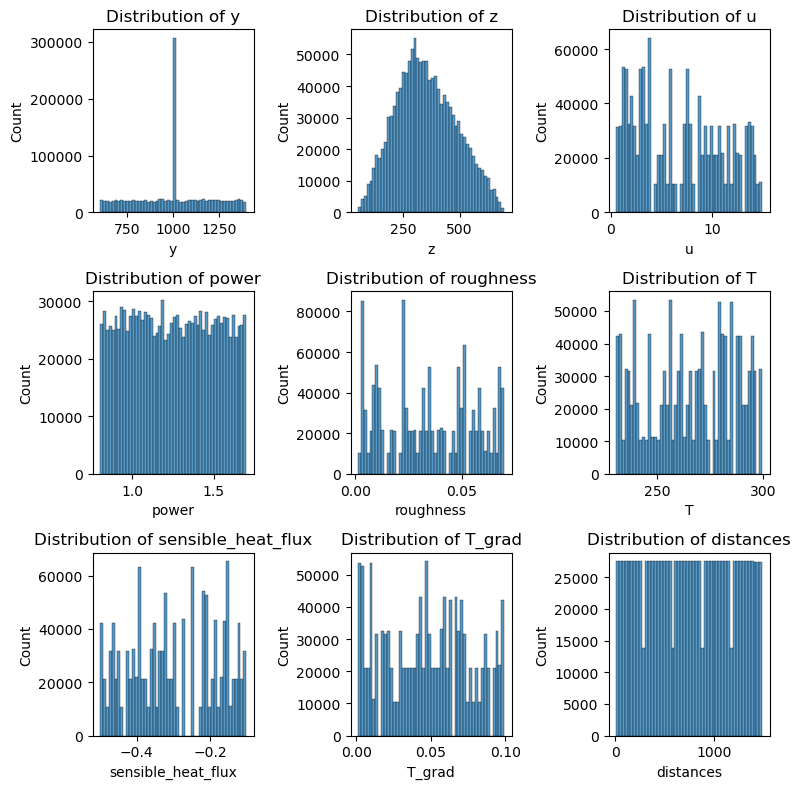

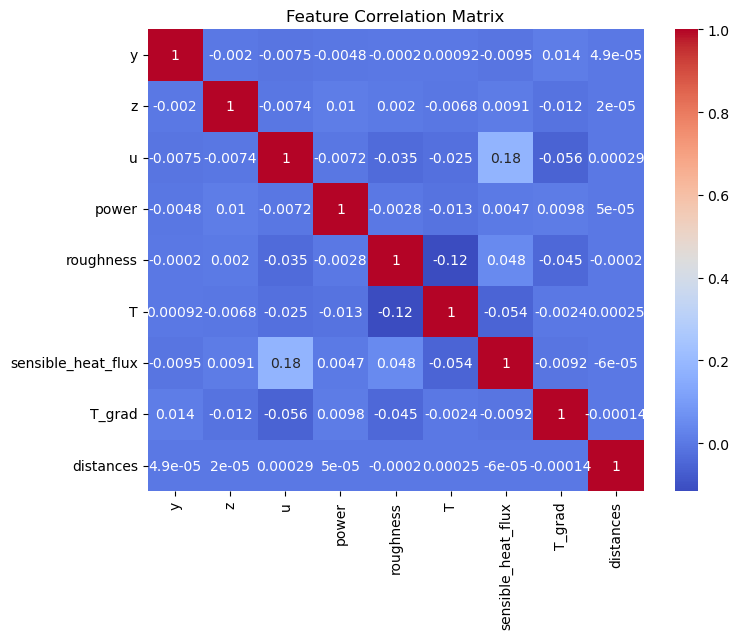

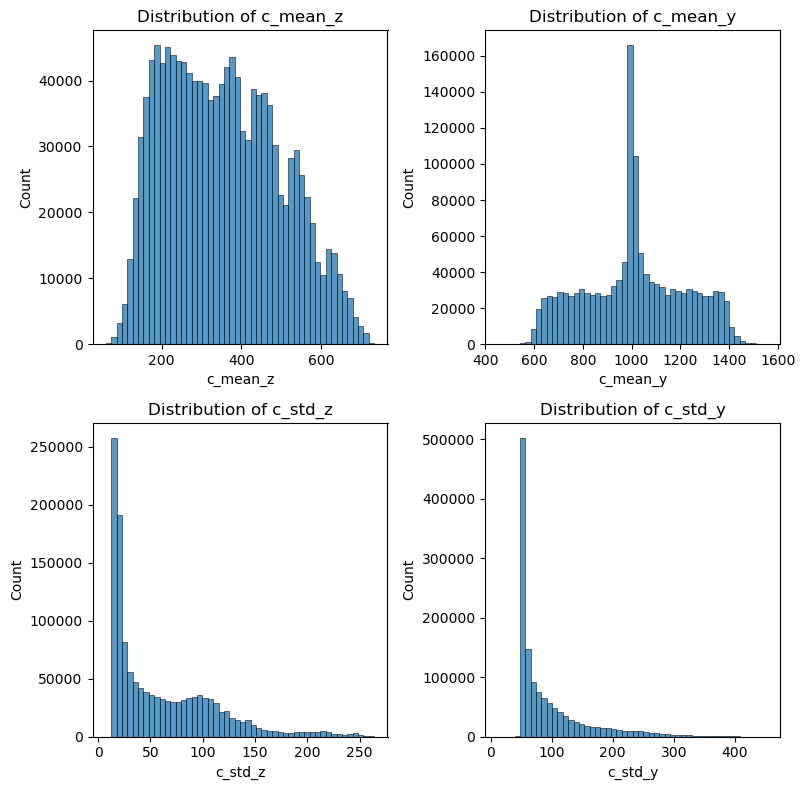

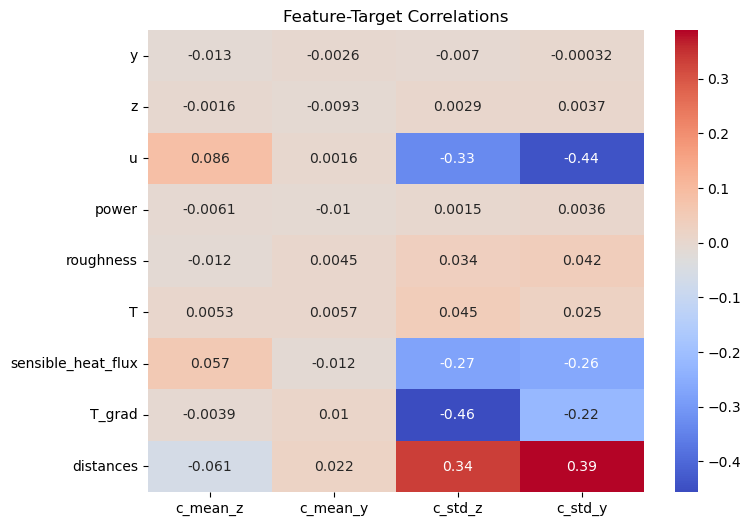

In [10]:
perform_eda(X, y)

## Test-train split

In [11]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [ ]:
# for small dataset
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [ ]:
# for small dataset
X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((596090, 9), (596090, 4), (66233, 9), (66233, 4))

In [11]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((760337, 9), (760337, 4), (211205, 9), (211205, 4), (84482, 9), (84482, 4))

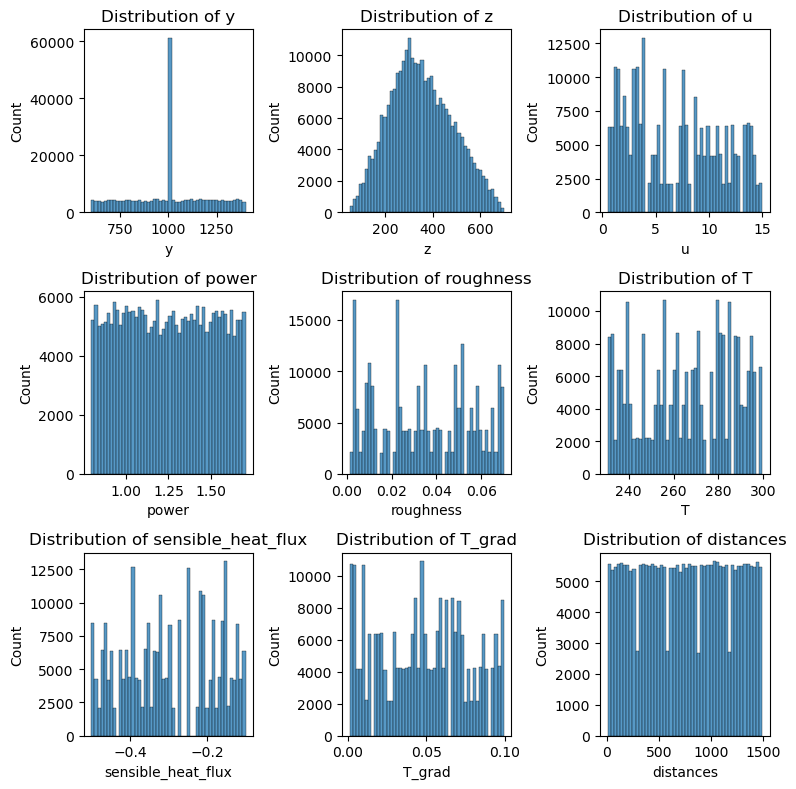

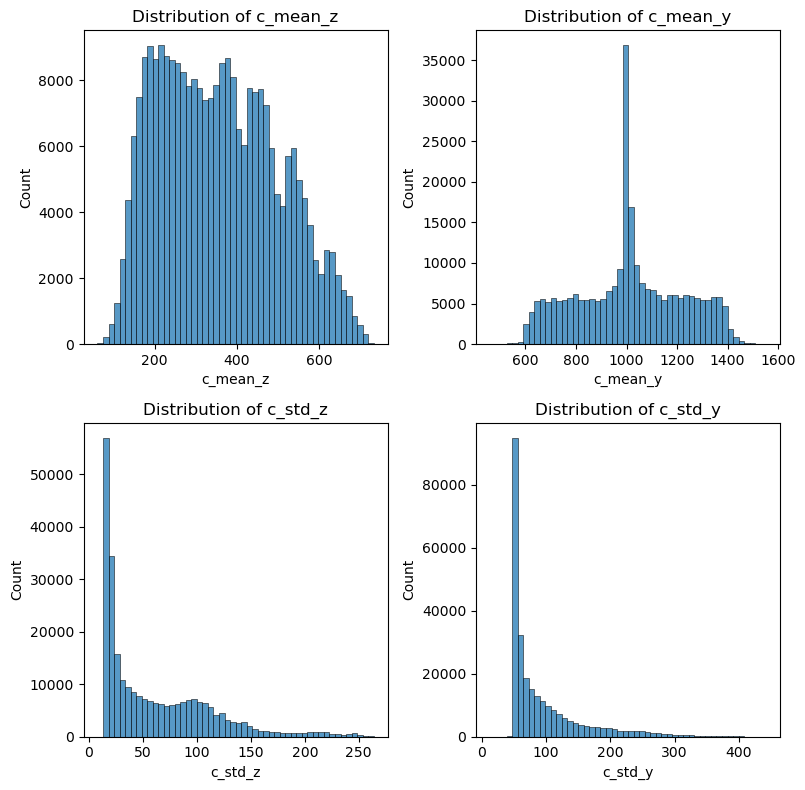

In [13]:
perform_eda_short(X_test, y_test)

## Feature engineering

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [53]:

class TargetPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, near_zero = 1e-4):
        self.near_zero = near_zero

    def fit(self, data: pd.DataFrame, *args):
        self.columns = data.columns
        self.std_y_bias = np.min(data["c_std_y"][data["c_std_y"] > 0])
        self.std_z_bias = np.min(data["c_std_z"][data["c_std_z"] > 0])
        self.mean_y_mean = np.mean(data["c_mean_y"])
        self.mean_z_mean = np.mean(data["c_mean_z"])
        self.mean_y_std = np.std(data["c_mean_y"])
        self.mean_z_std = np.std(data["c_mean_z"])

        return self

    def transform(self, data: pd.DataFrame):
        # data["c_std_y"] -= self.std_y_bias 
        # data["c_std_z"] -= self.std_z_bias
        
        data["c_std_y"] = np.log1p(data["c_std_y"])
        data["c_std_z"] = np.log1p(data["c_std_z"])

        

        # data["c_mean_y"] -= self.mean_y_mean        
        # mean_y_sign =  np.sign(data["c_mean_y"])
        # self.mean_y_sign = mean_y_sign
        # data["c_mean_y"] = np.abs(data["c_mean_y"])        
        # data["c_mean_y"] = np.log(np.abs(data["c_mean_y"]))
        # self.mean_y_log_max = np.max(data["c_mean_y"]) 
        # data["c_mean_y"] -= self.mean_y_log_max
        # data["c_mean_y"] = data["c_mean_y"] * mean_y_sign

        # data["c_mean_z"] -= self.mean_z_mean
        # mean_z_sign =  np.sign(data["c_mean_z"])
        # self.mean_z_sign = mean_z_sign
        # data["c_mean_z"] = np.log(np.abs(data["c_mean_z"]))
        # self.mean_z_log_max = np.max(data["c_mean_z"]) 
        # data["c_mean_z"] -= self.mean_z_log_max
        # data["c_mean_z"] = data["c_mean_z"] * mean_z_sign
        data["c_mean_z"] = (data["c_mean_z"] - self.mean_z_mean)/self.mean_z_std

        return data
    
    def inverse_transform(self, data: pd.DataFrame):
        data["c_std_y"] = np.expm1(data["c_std_y"])
        data["c_std_z"] = np.expm1(data["c_std_z"])
        # data["c_std_y"] += self.std_y_bias
        # data["c_std_z"] += self.std_z_bia

        # data["c_mean_y"] *= self.mean_y_sign
        # data["c_mean_y"] += self.mean_y_log_max
        # data["c_mean_y"] = np.exp(data["c_mean_y"])
        # data["c_mean_y"] *= self.mean_y_sign
        # data["c_mean_z"] *= self.mean_z_sign
        # data["c_mean_z"] += self.mean_z_log_max
        # data["c_mean_z"] = np.exp(data["c_mean_z"])
        # data["c_mean_z"] *= self.mean_z_sign
        
        # data["c_mean_y"] += self.mean_y_mean
        # data["c_mean_z"] += self.mean_z_mean
        data["c_mean_z"] = data["c_mean_z"] * self.mean_z_std + self.mean_z_mean
        return data

In [54]:
y_train_1 = y_train.copy()

In [55]:
target_pr = TargetPreprocessor()
target_pr.fit(y_train_1)

TargetPreprocessor()

In [56]:
target_pr.transform(y_train_1)

,c_mean_z,c_mean_y,c_std_z,c_std_y
387920,0.400103,967.898881,3.141589,4.040787
868210,-1.234802,1188.938923,4.571146,4.817156
718556,-0.393851,1240.730867,3.704170,4.301906
308041,0.862558,1311.995245,2.966460,4.064073
297010,0.526479,686.585559,3.081008,3.993760
...,...,...,...,...
158526,-0.664371,999.890487,3.399194,4.058016
184427,0.707591,1002.678631,3.294796,4.044890
166365,0.630747,999.671423,2.950270,3.974701
884629,1.799759,1321.253979,3.236026,4.027060


In [57]:
y_eval_1 = y_eval.copy()
target_pr.transform(y_eval_1)

,c_mean_z,c_mean_y,c_std_z,c_std_y
1135856,0.129636,1184.237519,3.995573,4.474924
269506,-0.727353,1012.994988,4.460248,4.573313
1290451,0.466819,698.891470,3.268778,4.019464
1071300,0.068851,1101.236561,2.847117,3.946936
412133,-1.261335,750.589784,3.904452,4.063919
...,...,...,...,...
866376,-1.478032,1368.155150,4.490099,5.179450
381652,1.618741,657.439853,3.007666,3.961629
126688,-1.285870,985.522998,4.684213,5.332630
1027344,0.549289,1027.527849,3.855741,4.169122


In [56]:
target_pr.transform(y_valid)

,c_mean_z,c_mean_y,c_std_z,c_std_y
365016,0.295979,-0.995892,5.264426,0.581313
841723,-0.442550,1.778371,3.890791,-0.190206
222748,-0.883850,2.158962,4.883979,1.230131
332828,0.387842,0.788540,2.922192,0.233835
198645,0.057401,4.123348,2.933978,-0.207765
...,...,...,...,...
11089,-0.071009,4.727533,4.094240,0.058778
338214,-0.025003,-0.620787,2.783229,0.279962
135343,-1.481912,-5.261634,4.391977,0.536583
942787,0.467233,1.147236,3.809595,-0.032857


array([[<Axes: title={'center': 'c_mean_z'}>,
        <Axes: title={'center': 'c_mean_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

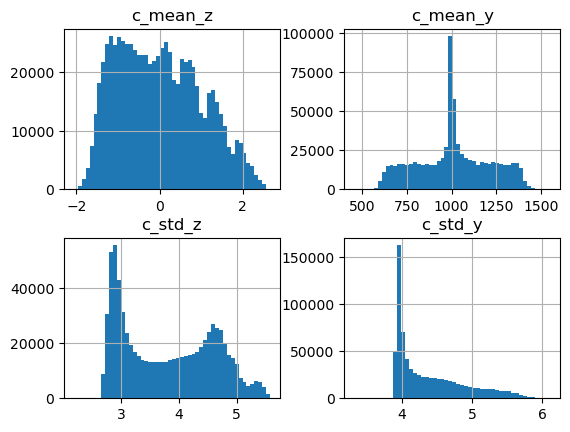

In [51]:
y_train_1.hist(bins=50)

## Models

## Catboost with optuna

In [58]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'Depthwise',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [60]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
study.optimize(objective, n_trials=1000, n_jobs=-1, timeout=7200)

[I 2025-02-07 13:51:00,864] A new study created in memory with name: catboost-seed42
[W 2025-02-07 13:51:01,299] Trial 10 failed with parameters: {'learning_rate': 0.0030987964106992, 'depth': 1, 'l2_leaf_reg': 0.029565319766000187, 'min_child_samples': 16} because of the following error: CatBoostError('/src/catboost/catboost/cuda/cuda_lib/devices_provider.h:190: Error: device already requested 0').
Traceback (most recent call last):
  File "/app/tmp/anaconda3/envs/nse/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4963/814353552.py", line 21, in objective
    regressor.fit(X_train.copy(), y_train.copy(),
  File "/app/tmp/anaconda3/envs/nse/lib/python3.12/site-packages/catboost/core.py", line 5807, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^

CatBoostError: /src/catboost/catboost/cuda/cuda_lib/devices_provider.h:190: Error: device already requested 0

In [ ]:
# print(study.best_value)
# print(study.best_params)

In [59]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 16}

In [60]:
params = {
    "learning_rate": best_params['learning_rate'],
    "depth": best_params['depth'],
    "l2_leaf_reg": best_params['l2_leaf_reg'],
    "min_child_samples": best_params['min_child_samples'],
    "grow_policy": 'Depthwise',
    "iterations": 1000,
    "use_best_model": True,
    "eval_metric": 'RMSE',
    "loss_function": 'RMSE',
    "thread_count": -1,
    "od_type": 'iter',
    "od_wait": 20,
    # "task_type":"GPU",
    # "devices":'0',
    "random_state": random_seed,
    "logging_level": 'Silent'
}   

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
# %%time
# y_pred ={}
# regressors = {}
# for target in ["c_mean_y", "c_mean_z"]:
    
#     optimized_regressor = TransformedTargetRegressor(CatBoostRegressor(**params),
#                                                     transformer = StandardScaler())

#     optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
#                             eval_set=[(X_eval.copy(), y_eval[target].copy())],
#                             early_stopping_rounds=early_stopping_round)
#     y_pred_tmp = optimized_regressor.predict(X_test.copy())
#     y_pred[target] = y_pred_tmp 
#     regressors[target] = optimized_regressor
# for target in ["c_std_y", "c_std_z"]:
    
#     optimized_regressor = TransformedTargetRegressor(CatBoostRegressor(**params),
#                                                     func = np.log,
#                                                     inverse_func=np.exp
#                                                     )
    
#     optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
#                             eval_set=[(X_eval.copy(), y_eval[target].copy())],
#                             early_stopping_rounds=early_stopping_round)
#     y_pred_tmp = optimized_regressor.predict(X_test.copy())
#     y_pred[target] = y_pred_tmp
#     regressors[target] = optimized_regressor

CPU times: user 22h 36min 54s, sys: 3h 31min 21s, total: 1d 2h 8min 15s
Wall time: 15min 47s


In [61]:
%%time
y_pred ={}
regressors = {}
for target in ["c_mean_y", "c_mean_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)

    optimized_regressor.fit(X_train.copy(), y_train_1[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval_1[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor
for target in ["c_std_y", "c_std_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)
    
    optimized_regressor.fit(X_train.copy(), y_train_1[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval_1[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor

CPU times: user 21h 40min 1s, sys: 4h 34min 2s, total: 1d 2h 14min 3s
Wall time: 19min 53s


In [62]:
target_pr.inverse_transform(y_pred)

{'c_mean_y': array([ 925.54389443,  999.61642016,  997.53566107, ..., 1059.23429627,
         869.93076669,  998.45188997]),
 'c_mean_z': array([490.33615293, 183.11753075, 309.20075374, ..., 248.419327  ,
        256.8194289 , 334.04426009]),
 'c_std_y': array([ 58.86287669,  62.79985603, 114.21036873, ...,  57.92110634,
         93.12824852,  55.65976211]),
 'c_std_z': array([20.14146238, 39.25322947, 80.94141861, ..., 36.45883478,
        80.69592733, 37.22260169])}

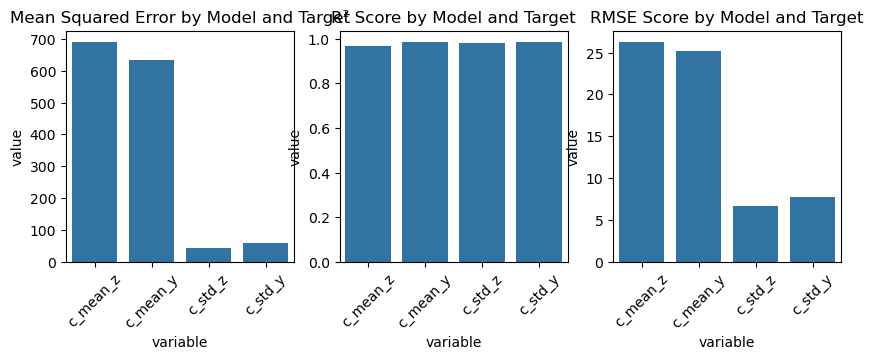

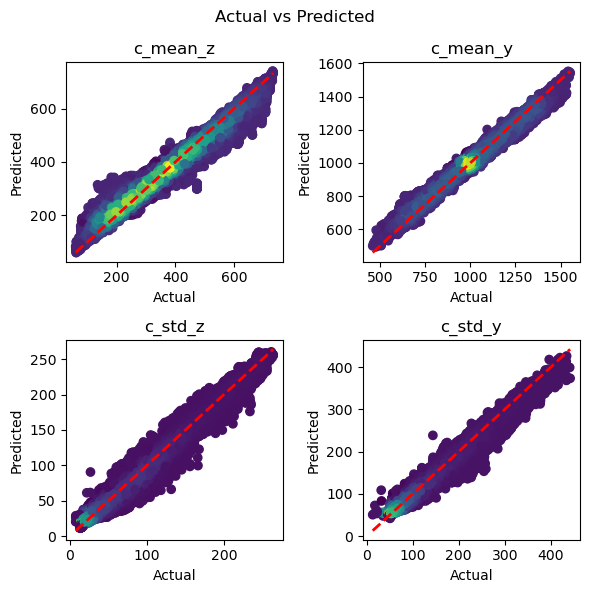

                 mse        r2       rmse
c_mean_z  690.867596  0.966107  26.284360
c_mean_y  632.762818  0.985103  25.154777
c_std_z    44.800671  0.982176   6.693330
c_std_y    59.967685  0.982690   7.743880


In [63]:
performance_visualizations(y_pred, y_test)

array([[<Axes: title={'center': 'c_mean_y'}>,
        <Axes: title={'center': 'c_mean_z'}>],
       [<Axes: title={'center': 'c_std_y'}>,
        <Axes: title={'center': 'c_std_z'}>]], dtype=object)

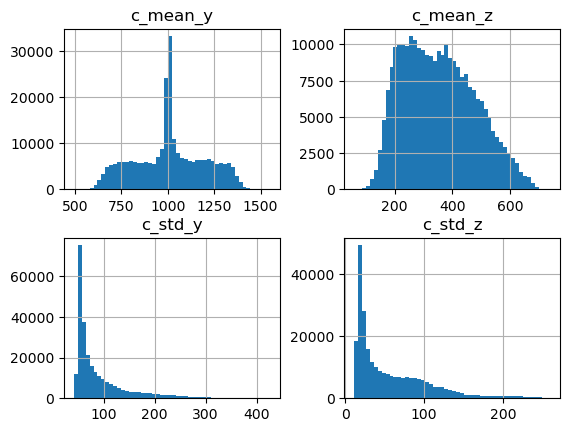

In [64]:
pd.DataFrame.from_dict(y_pred).hist(bins=50)

In [66]:
print(regressors["c_mean_y"].predict(specific_features))
print(regressors["c_std_y"].predict(specific_features))

[971.24424704]
[4.46791407]


## NN

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
%%time
y_pred ={}
for target in ["c_mean_y", "c_mean_z"]:
    
    mlp_regressor = TransformedTargetRegressor(MLPRegressor(),
                                                    transformer = StandardScaler())

    mlp_regressor.fit(X_train.copy(), y_train[target].copy())
    y_pred_tmp = mlp_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp 

for target in ["c_std_y", "c_std_z"]:
    
    mlp_regressor = TransformedTargetRegressor(MLPRegressor(),
                                                    func = np.log,
                                                    inverse_func=np.exp
                                                    )
    
    mlp_regressor.fit(X_train.copy(), y_train[target].copy())
    y_pred_tmp = mlp_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp

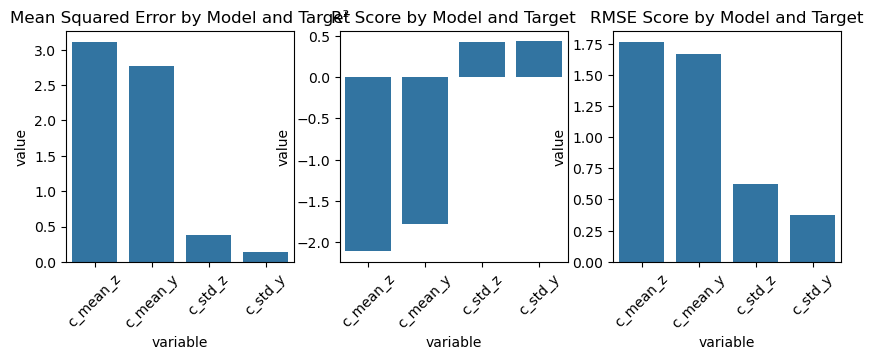

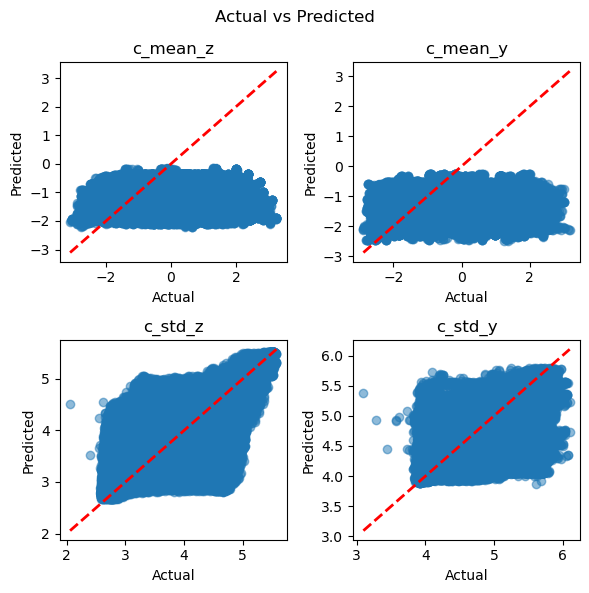

               mse        r2      rmse
c_mean_z  3.111740 -2.112511  1.764013
c_mean_y  2.775376 -1.778983  1.665946
c_std_z   0.384930  0.432031  0.620427
c_std_y   0.142001  0.434069  0.376831


In [ ]:
performance_visualizations(y_pred, y_test)